In [12]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [13]:
def sir_system_implicit(vars, S_prev, I_prev, R_prev, D_prev, V_prev, beta, gamma, death, mu, c, v_rate, econ_impact, dt, is_development_phase):
    S_new, I_new, R_new, D_new, V_new = vars[:3], vars[3:6], vars[6:9], vars[9:12], vars[12:15]
    S_prev, I_prev, R_prev, D_prev, V_prev = np.array(S_prev), np.array(I_prev), np.array(R_prev), np.array(D_prev), np.array(V_prev)
    F = np.zeros(15)

    effective_beta = beta.copy()
    if is_development_phase:
        effective_beta[:, 1] += econ_impact  # Increase interaction rates for blue-collar workers while vaccine is being worked on

    F[0:3] = S_new - S_prev + dt * (effective_beta @ I_new * S_new * c - mu * R_new + v_rate * S_new * (1 - is_development_phase))
    F[3:6] = I_new - I_prev - dt * (effective_beta @ I_new * S_new * c - gamma * I_new - death * I_new)
    F[6:9] = R_new - R_prev - dt * (gamma * I_new - mu * R_new - v_rate * R_new * (1 - is_development_phase))
    F[9:12] = D_new - D_prev - dt * death * I_new
    F[12:15] = V_new - V_prev - dt * v_rate * (S_new + R_new) * (1 - is_development_phase)
    
    return F

In [14]:
def sir_model_implicit_euler_matrix(S0, I0, R0, D0, V0, beta, gamma, dt, death, mu, v_rate, econ_impact, T, c, development_time):
    S = np.array(S0)
    I = np.array(I0)
    R = np.array(R0)
    D = np.array(D0)
    V = np.array(V0)

    num_steps = int(T / dt)
    development_steps = int(development_time / dt)
    
    S_list, I_list, R_list, D_list, V_list = [S], [I], [R], [D], [V]
    
    for i in range(num_steps):
        S_prev, I_prev, R_prev, D_prev, V_prev = S, I, R, D, V
        is_development_phase = i < development_steps

        sol = opt.root(sir_system_implicit, np.concatenate((S, I, R, D, V)), 
                       args=(S_prev, I_prev, R_prev, D_prev, V_prev, beta, gamma, death, mu, c, v_rate, econ_impact, dt, is_development_phase))
        sol = sol.x

        S, I, R, D, V = sol[:3], sol[3:6], sol[6:9], sol[9:12], sol[12:15]
        S_list.append(S)
        I_list.append(I)
        R_list.append(R)
        D_list.append(D)
        V_list.append(V)

    return np.array(S_list), np.array(I_list), np.array(R_list), np.array(D_list), np.array(V_list)

In [18]:
S0 = [0.99, 0.99, 0.99]  # Initial susceptible population
I0 = [0.01, 0.01, 0.01]  # Initial infected population
R0 = [0.0, 0.0, 0.0]     # Initial recovered population
D0 = [0.0, 0.0, 0.0]     # Initial dead population
V0 = [0.0, 0.0, 0.0]     # Initial vaccinated population

beta = np.array([[0.25, 0.3, 0.07], # ww, wb, wo
                 [0.5, 0.9, 0.07], # bw, bb, bo
                 [0.06, 0.05, 0.08]]) # ow, ob, oo

# Infection Rate
c = 0.6

# Chance of recovery per day of being infected
gamma = np.array([0.09, 0.09, 0.045])

# Death Rates
death = np.array([0.003, 0.004, 0.006])

# Rates of immunity loss
mu = np.array([0.001, 0.001, 0.0014])

# Vaccination rate
v_rate = np.array([0.03, 0.01, 0.005])

# Economic impact of costs of developing vaccine forcing more blue-collar work exposure
econ_impact = 0.1

dt = 0.01  # Time step
T = 100    # Total time
development_time = 25  # Time until the vaccine is developed

S_list, I_list, R_list, D_list, V_list = sir_model_implicit_euler_matrix(S0, I0, R0, D0, V0, beta, gamma, dt, death, mu, v_rate, econ_impact, T, c, development_time)

time = np.arange(0, T + dt, dt)


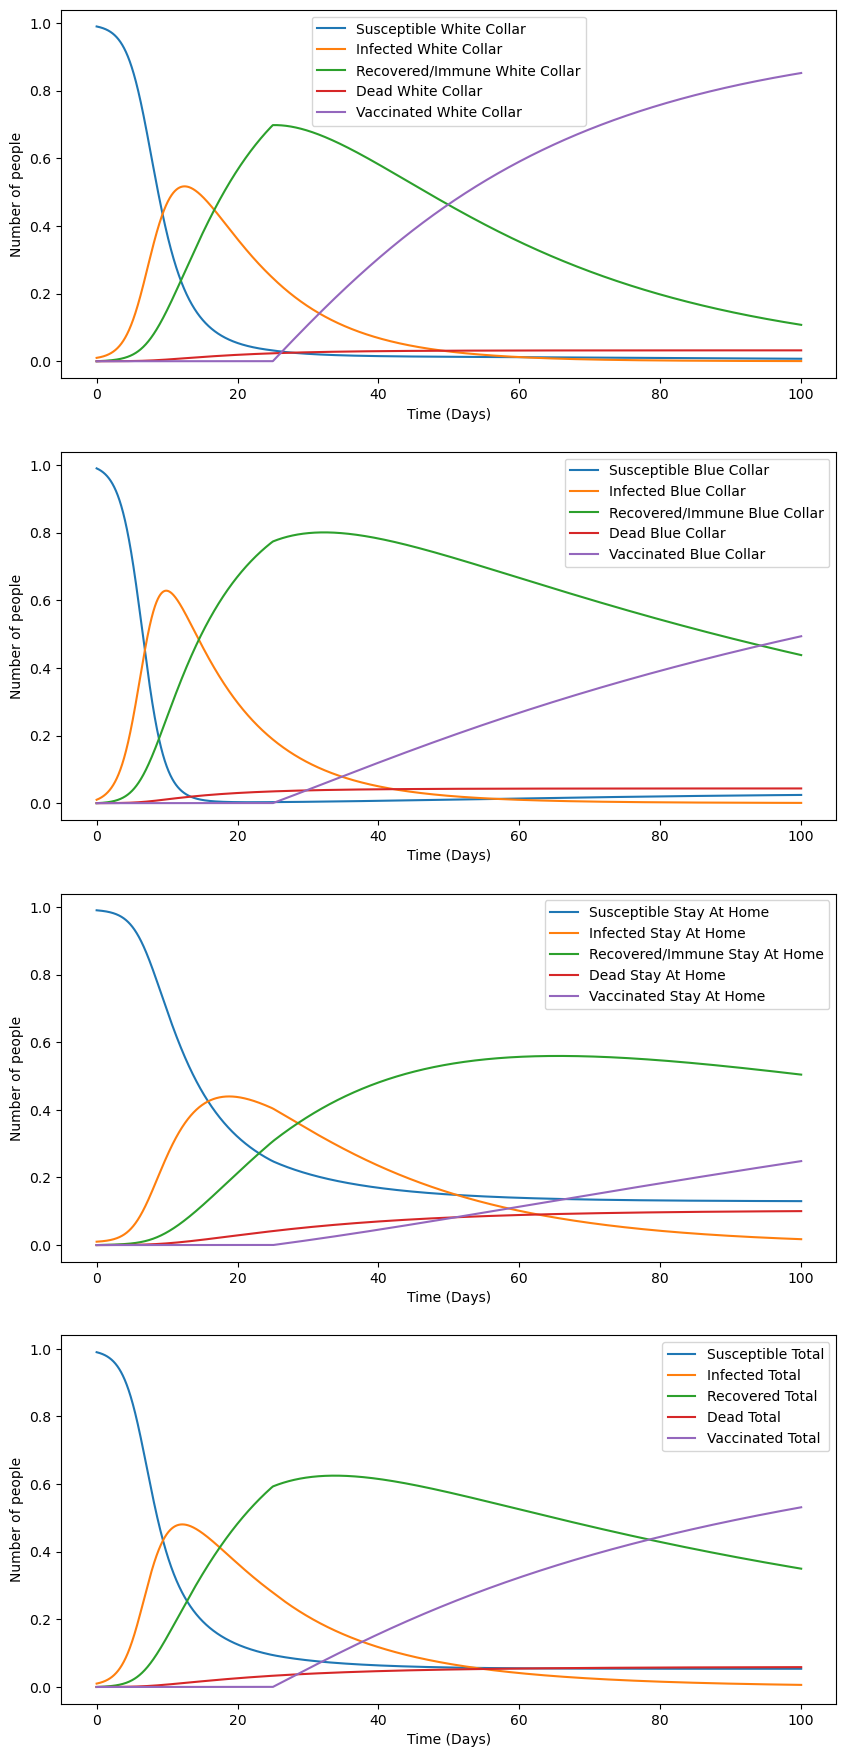

In [19]:
fig, ax = plt.subplots(4, 1, figsize=(10, 22))

ax[0].plot(time, S_list[:, 0], label='Susceptible White Collar')
ax[0].plot(time, I_list[:, 0], label='Infected White Collar')
ax[0].plot(time, R_list[:, 0], label='Recovered/Immune White Collar')
ax[0].plot(time, D_list[:, 0], label='Dead White Collar')
ax[0].plot(time, V_list[:, 0], label='Vaccinated White Collar')
ax[1].plot(time, S_list[:, 1], label='Susceptible Blue Collar')
ax[1].plot(time, I_list[:, 1], label='Infected Blue Collar')
ax[1].plot(time, R_list[:, 1], label='Recovered/Immune Blue Collar')
ax[1].plot(time, D_list[:, 1], label='Dead Blue Collar')
ax[1].plot(time, V_list[:, 1], label='Vaccinated Blue Collar')
ax[2].plot(time, S_list[:, 2], label='Susceptible Stay At Home')
ax[2].plot(time, I_list[:, 2], label='Infected Stay At Home')
ax[2].plot(time, R_list[:, 2], label='Recovered/Immune Stay At Home')
ax[2].plot(time, D_list[:, 2], label='Dead Stay At Home')
ax[2].plot(time, V_list[:, 2], label='Vaccinated Stay At Home')
ax[3].plot(time, np.sum(S_list, axis=1) / 3, label='Susceptible Total')
ax[3].plot(time, np.sum(I_list, axis=1) / 3, label='Infected Total')
ax[3].plot(time, np.sum(R_list, axis=1) / 3, label='Recovered Total')
ax[3].plot(time, np.sum(D_list, axis=1) / 3, label='Dead Total')
ax[3].plot(time, np.sum(V_list, axis=1) / 3, label='Vaccinated Total')

for i in range(4):
    ax[i].set_xlabel('Time (Days)')
    ax[i].set_ylabel('Number of people')
    ax[i].legend()

plt.show()

In [20]:
print("End: ")
print(f'White Collar: \n Susceptible: {S_list[:,0][-1]} \n Infected: {I_list[:,0][-1]} \n Recovered: {R_list[:,0][-1]} \n Dead: {D_list[:,0][-1]} \n Vaccinated: {V_list[:,1][-1]}')
print(f'Blue Collar: \n Susceptible: {S_list[:,1][-1]} \n Infected: {I_list[:,1][-1]} \n Recovered: {R_list[:,1][-1]} \n Dead: {D_list[:,1][-1]} \n Vaccinated: {V_list[:,0][-1]}')
print(f'Stay at Home: \n Susceptible: {S_list[:,2][-1]} \n Infected: {I_list[:,2][-1]} \n Recovered: {R_list[:,2][-1]} \n Dead: {D_list[:,2][-1]} \n Vaccinated: {V_list[:,2][-1]}')
print(f'Total: \n Suceptible: {np.sum(S_list[-1])} \n Infected: {np.sum(I_list[-1])} \n Recovered: {np.sum(R_list[-1])} \n Dead: {np.sum(D_list[-1])} \n Vaccinated: {np.sum(V_list[-1])}')

print("")
print(f'Max infected:  \n White Collar: {np.max(I_list[:,0])} \n Blue Collar: {np.max(I_list[:,1])} \n Stay at Home: {np.max(I_list[:,2])} \n Total: {np.max(I_list[:,0] + I_list[:,1] + I_list[:,2])/3}') 

End: 
White Collar: 
 Susceptible: 0.0073562998962191355 
 Infected: 0.0004635140822419149 
 Recovered: 0.10764118490366842 
 Dead: 0.032190159868882566 
 Vaccinated: 0.4935700384499458
Blue Collar: 
 Susceptible: 0.024305234634866845 
 Infected: 0.0007726225184674785 
 Recovered: 0.4378713434262113 
 Dead: 0.04348076097050849 
 Vaccinated: 0.8523488412489888
Stay at Home: 
 Susceptible: 0.1298956397831408 
 Infected: 0.017379526367721325 
 Recovered: 0.5040610694322524 
 Dead: 0.10037995310990258 
 Vaccinated: 0.24828381130698135
Total: 
 Suceptible: 0.16155717431422678 
 Infected: 0.01861566296843072 
 Recovered: 1.049573597762132 
 Dead: 0.17605087394929364 
 Vaccinated: 1.594202691005916

Max infected:  
 White Collar: 0.5171778243919631 
 Blue Collar: 0.6283129730618595 
 Stay at Home: 0.4395204549580631 
 Total: 0.48078151603173475
